In [1]:
# !sudo pip3 install -U -q PyMySQL sqlalchemy sql_magic tqdm

In [2]:
import requests

In [3]:
# This gives information for each station that remains stable over time
url_stations = "https://gbfs.citibikenyc.com/gbfs/en/station_information.json"

In [4]:
# This gives the live status of all the stations (e.g., bikes available etc)
url_status = "https://gbfs.citibikenyc.com/gbfs/en/station_status.json"

In [5]:
# We fetch for now just the time-invariant data
results = requests.get(url_stations).json()

In [6]:
# We only need a subset of the data in the JSON returned by the Citibike API, so we keep only what we need
stations = results["data"]["stations"]

In [7]:
# We will not be using dataframes for this insertion task. (See the A6 notebook if you want to use Pandas)
# We just put the data in a dataframe to understand what is going on.
import pandas as pd

df_stations = pd.DataFrame(stations)
df_stations.head(5)

,station_id,rental_uris,region_id,legacy_id,name,capacity,short_name,eightd_has_key_dispenser,external_id,has_kiosk,lat,lon,eightd_station_services,electric_bike_surcharge_waiver,station_type,rental_methods
0,72,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",71,72,W 52 St & 11 Ave,55,6926.01,False,66db237e-0aca-11e7-82f6-3863bb44ef7c,True,40.767272,-73.993929,[],False,classic,"[KEY, CREDITCARD]"
1,79,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",71,79,Franklin St & W Broadway,33,5430.08,False,66db269c-0aca-11e7-82f6-3863bb44ef7c,True,40.719116,-74.006667,[],False,classic,"[KEY, CREDITCARD]"
2,82,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",71,82,St James Pl & Pearl St,27,5167.06,False,66db277a-0aca-11e7-82f6-3863bb44ef7c,True,40.711174,-74.000165,[],False,classic,"[KEY, CREDITCARD]"
3,83,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",71,83,Atlantic Ave & Fort Greene Pl,62,4354.07,False,66db281e-0aca-11e7-82f6-3863bb44ef7c,True,40.683826,-73.976323,[],False,classic,"[KEY, CREDITCARD]"
4,116,"{'ios': 'https://bkn.lft.to/lastmile_qr_scan',...",71,116,W 17 St & 8 Ave,50,6148.02,False,66db28b5-0aca-11e7-82f6-3863bb44ef7c,True,40.741776,-74.001497,[],False,classic,"[KEY, CREDITCARD]"


In [8]:
import sqlalchemy
from sqlalchemy import create_engine

conn_string = "mysql://{user}:{password}@{host}/".format(
    host="db.ipeirotis.org", user="student", password="dwdstudent2015"
)

engine = create_engine(conn_string)

db_name = "public"
create_db_query = (
    f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET 'utf8'"
)

# Create a database
engine.execute(create_db_query)

# And lets switch to the database
engine.execute(f"USE {db_name}")

# To avoid conflicts between people writing in the same database, we add a random suffix in the tables
# We only create the variable once while running the notebook
import uuid

if "suffix" not in globals():
    suffix = str(uuid.uuid4())[:8]
print(suffix)

bc139831


In [9]:
# Create the two tables. One for storing the time-invariant station data
# and another table to store the time-varying station status data
stations_table = f"Stations_{suffix}"

sql = f"""CREATE TABLE IF NOT EXISTS {stations_table}
                                (station_id int, 
                                name varchar(250), 
                                capacity int,
                                lat float,
                                lon float,
                                region_id int,
                                short_name varchar(250),
                                rental_url varchar(250),
                                eightd_has_key_dispenser bool,
                                PRIMARY KEY(station_id)
                 )"""
engine.execute(sql)

In [10]:
# Create the time-varying table
status_table = f"Status_{suffix}"
sql = f"""CREATE TABLE IF NOT EXISTS {status_table}
                                (station_id int, 
                                last_reported datetime,
                                num_bikes_available int,
                                num_ebikes_available int,
                                num_bikes_disabled int,
                                num_docks_available int,
                                num_docks_disabled int,
                                is_installed bool,
                                is_renting bool,
                                is_returning bool,
                                PRIMARY KEY(station_id, last_reported)
                                )"""
engine.execute(sql)

In [11]:
stations[0]

{'station_id': '72',
 'rental_uris': {'ios': 'https://bkn.lft.to/lastmile_qr_scan',
  'android': 'https://bkn.lft.to/lastmile_qr_scan'},
 'region_id': '71',
 'legacy_id': '72',
 'name': 'W 52 St & 11 Ave',
 'capacity': 55,
 'short_name': '6926.01',
 'eightd_has_key_dispenser': False,
 'external_id': '66db237e-0aca-11e7-82f6-3863bb44ef7c',
 'has_kiosk': True,
 'lat': 40.76727216,
 'lon': -73.99392888,
 'eightd_station_services': [],
 'electric_bike_surcharge_waiver': False,
 'station_type': 'classic',
 'rental_methods': ['KEY', 'CREDITCARD']}

In [12]:
# We fetch for now just the time-invariant data
# Notice that we have the INSERT IGNORE so that even when we add the same entry
# again, we do not get an error that the line exists. We do get warnings
# but this is expected

from sqlalchemy.sql import text
from tqdm.autonotebook import tqdm

query_template = text(
    f"""INSERT IGNORE INTO {db_name}.{stations_table}
            (station_id, name, capacity, lat, lon,
            region_id, short_name, rental_url, eightd_has_key_dispenser) 
        VALUES (:station_id, :name, :capacity, :lat, :lon, :region_id, 
                    :short_name, :rental_url, :eightd_has_key_dispenser)"""
)

# The tqdm(stations) shows a progress bar
for entry in tqdm(stations):

    query_parameters = {
        "station_id": int(entry["station_id"]),
        "name": entry.get("name"),
        "capacity": entry.get("capacity"),
        "lat": entry.get("lat"),
        "lon": entry.get("lon"),
        "region_id": entry.get("region_id"),
        "short_name": entry.get("short_name"),
        "rental_url": entry.get("rental_url"),
        "eightd_has_key_dispenser": entry.get("eightd_has_key_dispenser"),
    }

    engine.execute(query_template, **query_parameters)

<ipython-input-12-ea1ed18d7525>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [13]:
check = pd.read_sql(f"SELECT * FROM {db_name}.{stations_table}", con=engine)
check

,station_id,name,capacity,lat,lon,region_id,short_name,rental_url,eightd_has_key_dispenser
0,72,W 52 St & 11 Ave,55,40.7673,-73.9939,71.0,6926.01,None,0
1,79,Franklin St & W Broadway,33,40.7191,-74.0067,71.0,5430.08,None,0
2,82,St James Pl & Pearl St,27,40.7112,-74.0002,71.0,5167.06,None,0
3,83,Atlantic Ave & Fort Greene Pl,62,40.6838,-73.9763,71.0,4354.07,None,0
4,116,W 17 St & 8 Ave,50,40.7418,-74.0015,71.0,6148.02,None,0
...,...,...,...,...,...,...,...,...,...
1388,4430,63 St & 5 Ave,0,40.6377,-74.0178,71.0,2872.02,None,0
1389,4435,4 Ave & 17 St,0,40.6655,-73.9930,71.0,3739.06,None,0
1390,4436,Park Cir & East Dr,0,40.6516,-73.9722,71.0,3344.02,None,0
1391,4449,Ocean Pkwy & Church Ave,0,40.6453,-73.9742,71.0,3125.09,None,0


<AxesSubplot:xlabel='lon', ylabel='lat'>

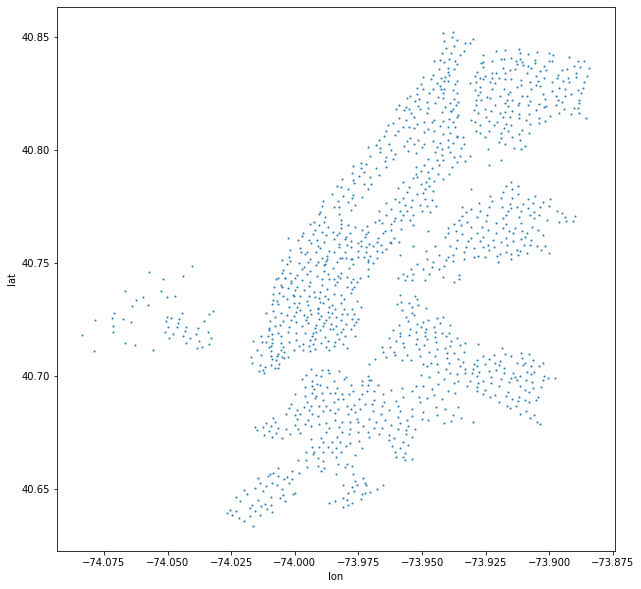

In [14]:
%matplotlib inline
check.plot(kind="scatter", x="lon", y="lat", s=1, figsize=(10, 10))

In [15]:
results = requests.get(url_status).json()
status = results["data"]["stations"]
status[0]

{'station_id': '72',
 'legacy_id': '72',
 'num_ebikes_available': 6,
 'eightd_has_available_keys': False,
 'station_status': 'active',
 'num_docks_available': 41,
 'is_renting': 1,
 'num_bikes_disabled': 1,
 'is_returning': 1,
 'num_bikes_available': 13,
 'last_reported': 1615949221,
 'num_docks_disabled': 0,
 'is_installed': 1}

In [16]:
# Now we fetch the data about the time varying elements of the citibike stations
from datetime import datetime

query_template = text(
    f"""INSERT IGNORE INTO {db_name}.{status_table}(station_id, 
                                            num_bikes_available,
                                            num_ebikes_available,
                                            num_bikes_disabled,
                                            num_docks_available,
                                            num_docks_disabled,
                                            is_installed,
                                            is_renting,
                                            is_returning,
                                            last_reported) 
                    VALUES (:station_id, :num_bikes_available, :num_ebikes_available, :num_bikes_disabled,
                    :num_docks_available, :num_docks_disabled, :is_installed, :is_renting, :is_returning, :last_reported)"""
)

for entry in tqdm(status):
    query_parameters = {
        "station_id": int(entry["station_id"]),
        "num_bikes_available": entry["num_bikes_available"],
        "num_bikes_disabled": entry["num_bikes_disabled"],
        "num_ebikes_available": entry["num_ebikes_available"],
        "num_docks_available": entry["num_docks_available"],
        "num_docks_disabled": entry["num_docks_disabled"],
        "is_installed": entry["is_installed"],
        "is_renting": entry["is_renting"],
        "is_returning": entry["is_returning"],
        "last_reported": datetime.fromtimestamp(entry["last_reported"]),
    }

    engine.execute(query_template, **query_parameters)

In [17]:
check = pd.read_sql(f"SELECT * FROM {db_name}.{status_table}", con=engine)
check

,station_id,last_reported,num_bikes_available,num_ebikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning
0,72,2021-03-17 02:47:01,13,6,1,41,0,1,1,1
1,79,2021-03-17 00:58:55,23,0,2,8,0,1,1,1
2,82,2021-03-17 02:27:54,19,1,1,7,0,1,1,1
3,83,2021-03-17 01:02:42,49,1,0,13,0,1,1,1
4,116,2021-03-17 03:11:38,22,1,1,27,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...
1388,4430,1970-01-02 00:00:00,0,0,0,0,0,0,0,0
1389,4435,1970-01-02 00:00:00,0,0,0,0,0,0,0,0
1390,4436,1970-01-02 00:00:00,0,0,0,0,0,0,0,0
1391,4449,1970-01-02 00:00:00,0,0,0,0,0,0,0,0


In [18]:
drop_table_query = f"DROP TABLE IF EXISTS {db_name}.{status_table}"
print(drop_table_query)
engine.execute(drop_table_query)

DROP TABLE IF EXISTS public.Status_bc139831


In [19]:
drop_table_query = f"DROP TABLE IF EXISTS {db_name}.{stations_table}"
print(drop_table_query)
engine.execute(drop_table_query)

DROP TABLE IF EXISTS public.Stations_bc139831
